## Exercise

Load the national COVID dataset and solve the exercise using `scikit-learn` library.
Consider first the column corresponding to the (cumulative) number of deaths. 
1. Perform a train-test split, with observations from the last week corresponding to the test set;
2. Build a suitable combination of kernels choosing from the ones shown in `notebook_05`;
3. Fit a `GaussianProcessRegressor` to predict the daily number of swabs, plot future predictions and compare them to real test data;
4. Repeat points 1-3 on the daily number of swabs, which can be computed from the cumulative number provided in the dataset.

You are welcome to try out and fit other data streams in the dataset. 


#### Proposed solution:

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, DotProduct 
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
#load the dataset
covid_data = pd.read_csv("data/COVID_national_20200421.csv")

#remove "Unnamed 0" column
covid_data = covid_data.iloc[:,1:] 

# drop rows with nan
covid_data.dropna(inplace=True)

#fix date as index
covid_data['date'] = pd.to_datetime(covid_data['date'])
covid_data = covid_data.set_index('date')

covid_data.head()

,deaths,swabs,ICU,hospitalized,new_infections,cumulative_infections,recovered,quarantined
date,,,,,,,,
2020-02-24,7,4324,26,101,221,229,1,94
2020-02-25,10,8623,35,114,93,322,1,162
2020-02-26,12,9587,36,128,78,400,3,221
2020-02-27,17,12014,56,248,250,650,45,284
2020-02-28,21,15695,64,345,238,888,46,412


In [3]:
#function to convert datetime to number 
def dates_to_idx(timelist):
    reference_time = pd.to_datetime('2020-02-24')
    t = (timelist - reference_time) / pd.Timedelta(1, "D")
    return np.asarray(t)

In [4]:
#retrieve number of daily swabs
y = covid_data["swabs"].values
daily_swabs = [y[0] if i==0 else y[i] - y[i-1] for i in range(len(y))]

#days after the lower date reported in the dataset
day = dates_to_idx(covid_data.index)

#add “day“ and “daily swaps“ to the dataset
covid_data = covid_data.assign(day = day)
covid_data = covid_data.assign(daily_swabs = daily_swabs)
covid_data.head()

,deaths,swabs,ICU,hospitalized,new_infections,cumulative_infections,recovered,quarantined,day,daily_swabs
date,,,,,,,,,,
2020-02-24,7,4324,26,101,221,229,1,94,0.0,4324
2020-02-25,10,8623,35,114,93,322,1,162,1.0,4299
2020-02-26,12,9587,36,128,78,400,3,221,2.0,964
2020-02-27,17,12014,56,248,250,650,45,284,3.0,2427
2020-02-28,21,15695,64,345,238,888,46,412,4.0,3681


### 1.

In [5]:
# split into training and test set
sep_idx = covid_data.index.searchsorted(pd.to_datetime("2020-04-14"))
covid_train = covid_data.iloc[:sep_idx+1, :]
covid_test = covid_data.iloc[sep_idx:, :]

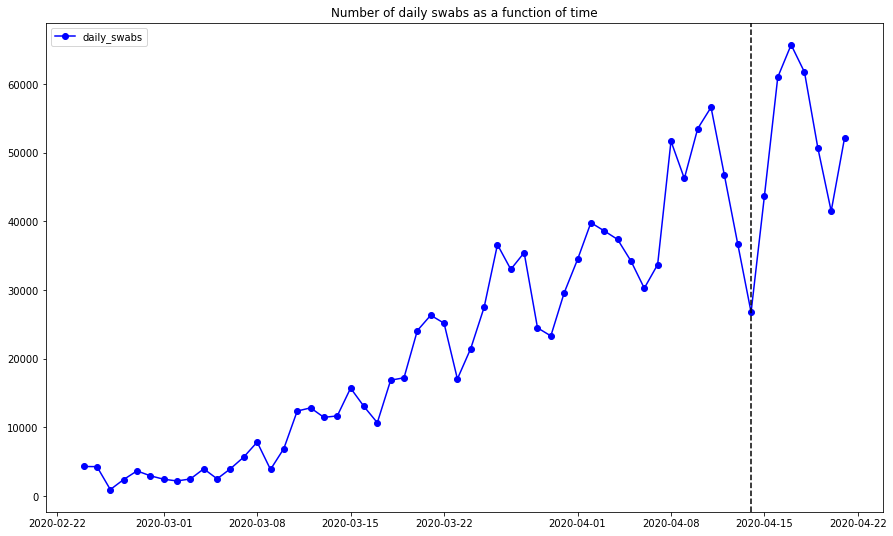

In [196]:
#graphical representation of the train-test split
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
ax.plot(covid_data.index, covid_data.daily_swabs, marker = 'o',
        color='b', label='daily_swabs')
ax.axvline(pd.to_datetime("2020-04-14"), linestyle='--', color='k')
ax.legend()
_=ax.set_title('Number of daily swabs as a function of time')

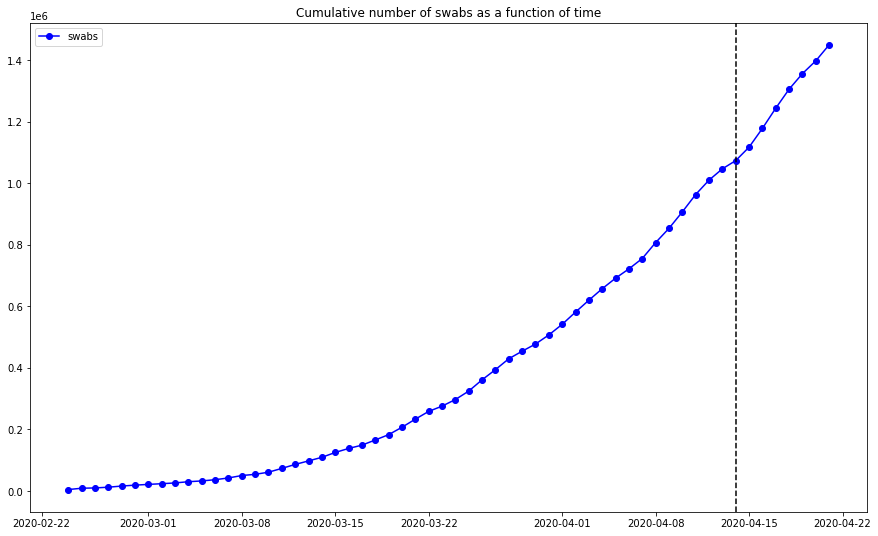

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
ax.plot(covid_data.index, covid_data.swabs, marker = 'o',
        color='b', label='swabs')
ax.axvline(pd.to_datetime("2020-04-14"), linestyle='--', color='k')
ax.legend()
_=ax.set_title('Cumulative number of swabs as a function of time')

### 2.

In [8]:
X = covid_data.day.values[:, None]
y = covid_data.daily_swabs.values
train_X = X[:len(covid_train)] 
train_y = y[:len(covid_train)] 
test_X = X[len(covid_test):]
test_y = y[len(covid_test):] 

Consider now the daily number of swabs. 

From the previous plot, it seems that there is a linear incresing trend over time in the data, with some periodicity (approximately a week, 7 days).

It seems then suitable to try to build a kernel made as combination of three pieces: a periodic kernel (to describe the period behaviour), an exponential kernel (to describe the increasing behaviour over time) and a third one to describe the noise (e.g. White kernel). 

In order to tune the parameters, I started with random guess and then change them until the output of `gp.kernel` was equal to `gp.kernel_`, being `gp` the fitted `GaussianProcessRegressor`.
Namely until the input parameters were equal to the optimized ones.

In [141]:
#long term increasing trend 
k1 = 316**2 * DotProduct(sigma_0=77.8) 
#weekly periodic trend
k2 = 316**2*ExpSineSquared(length_scale=1e-05, periodicity=7.0, periodicity_bounds="fixed")
#noise term
k3 = 316**2*RBF(length_scale=1e05) + WhiteKernel(noise_level=1e+05)
#we can also add another term to take into account medium term irregularities
k4 = 316**2*RationalQuadratic(alpha=1e+05, length_scale=1e-05)

k = k1+k2+k3+k4

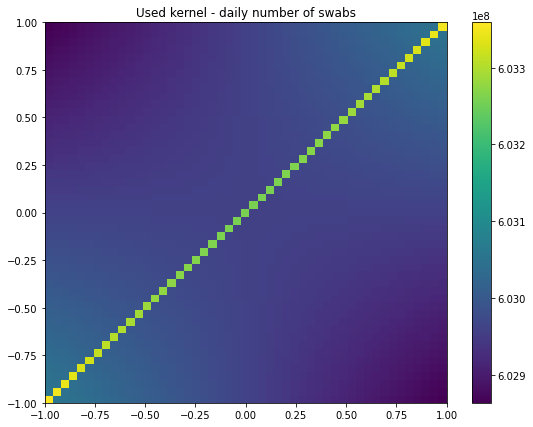

In [219]:
#visualize the kernel 
x = np.linspace(-1,1,50)
kernel = k(x[:, None])
plt.figure(figsize=(9,7))
plt.pcolor(x, x, kernel.reshape(len(x), len(x)))
plt.colorbar()
_=plt.title("Used kernel - daily number of swabs")

### 3.

In [166]:
#useful function (took from notebook_05)

def plot_predictions(gp, include_observed=True):
    pred_y, pred_std = gp.predict(X, return_std=True)
    plt.figure(figsize=(10, 5))
    x = X[:, 0]
    if include_observed:
        plt.plot(x, y, 'ok', alpha=0.1)
    l, = plt.plot(x, pred_y)
    plt.fill_between(x,
                     pred_y + pred_std,
                     pred_y - pred_std,
                     color=l.get_color(), alpha=0.3)
    if np.allclose(X[:, 0], covid_data.day.values):
        plt.axvline(dates_to_idx(pd.to_datetime("2020-04-14")), linestyle='--', color='k')
    else:
        plt.axvline(pd.to_datetime("2020-04-14"), linestyle='--', color='k')

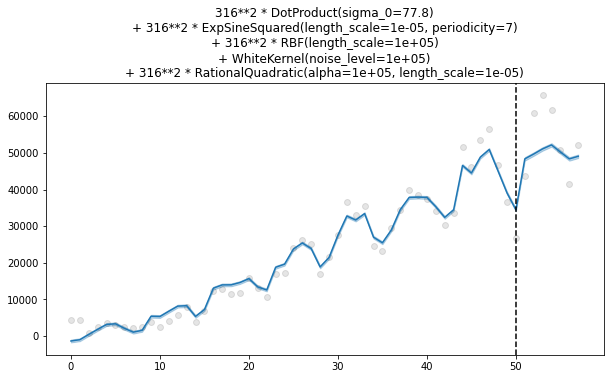

In [177]:
gp = GaussianProcessRegressor(kernel=k, alpha=0.0, normalize_y=True, n_restarts_optimizer=3)

gp.fit(train_X, train_y)

plot_predictions(gp)
_=plt.title(str(gp.kernel_).replace(' +', '\n+'))

Even if there are some peaks in the dataset that are ignored by the built model (especially in the test set), it seems to capture the general bahaviour of our data.

### 4.

Now we focus on the cumulative number of swabs. 

From the plot above it can be observed that the number of cumulative swabs increses in a quadratic way. 

In [179]:
X = covid_data.day.values[:, None]
y = covid_data.swabs.values
train_X = X[:len(covid_train)] 
train_y = y[:len(covid_train)] 
test_X = X[len(covid_test):]
test_y = y[len(covid_test):] 

In [189]:
#quadratic trend over time
kk1 = 316**2*DotProduct(sigma_0 = 28.6)**2
#noise term
kk2 = 316**2*RBF(length_scale=1e05) + WhiteKernel(noise_level=1e+05)

kk = kk1+kk2

Parameters have been tuned according to the criterium described above.

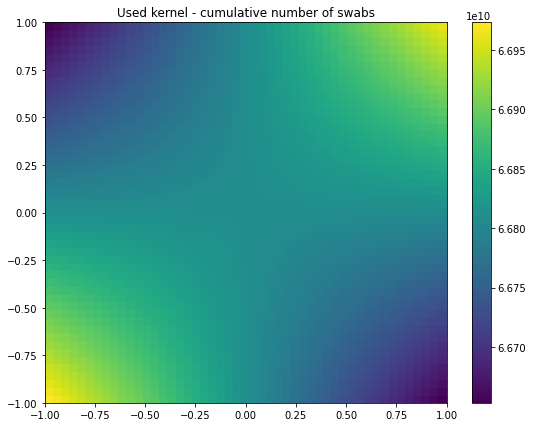

In [220]:
#visualize the kernel 
x = np.linspace(-1,1,50)
kernel = kk(x[:, None])
plt.figure(figsize=(9,7))
plt.pcolor(x, x, kernel.reshape(len(x), len(x)))
plt.colorbar()
_=plt.title("Used kernel - cumulative number of swabs")

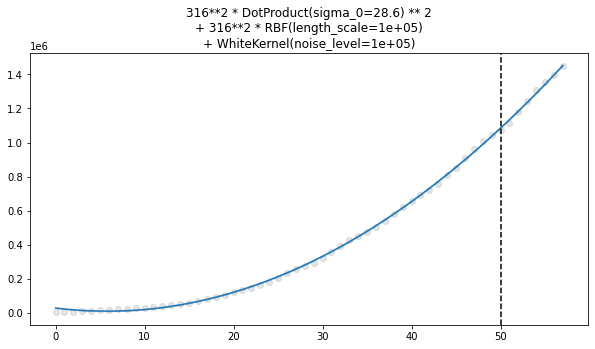

In [184]:
gp2 = GaussianProcessRegressor(kernel=kk, alpha=0.01, normalize_y=True, n_restarts_optimizer=3)

gp2.fit(train_X, train_y)

plot_predictions(gp2)
_=plt.title(str(gp2.kernel_).replace(' +', '\n+'))

The built regressor seem to model the dataset in a reliable way.

Now we can focus on the cumulative number of deaths:

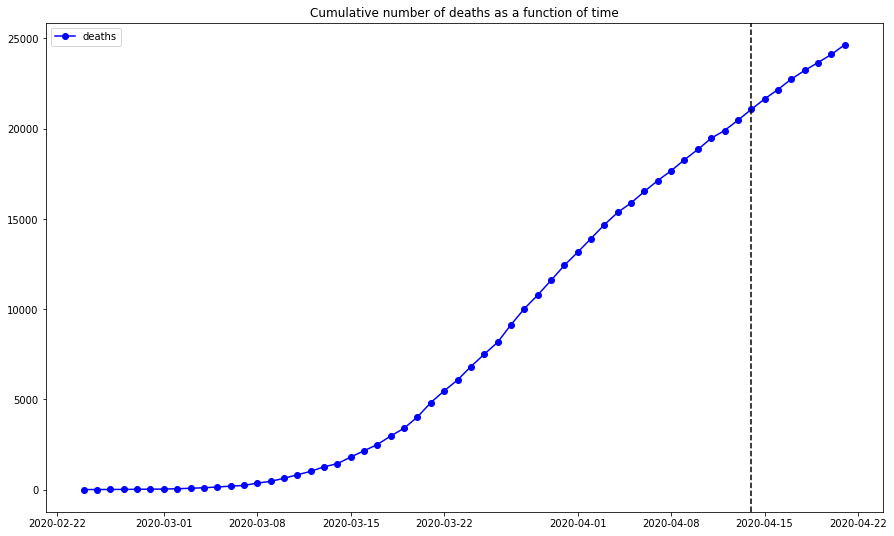

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
ax.plot(covid_data.index, covid_data.deaths, marker = 'o',
        color='b', label='deaths')
ax.axvline(pd.to_datetime("2020-04-14"), linestyle='--', color='k')
ax.legend()
_=ax.set_title('Cumulative number of deaths as a function of time')

From the plot it is possible to observe that the curve representing the number of deaths increases almost exponentially in the first part (coarsely until 2020-04-01), then the speed of the increasing trend slows down, increasing almost linearly from that point on.

In [198]:
X = covid_data.day.values[:, None]
y = covid_data.deaths.values
train_X = X[:len(covid_train)] 
train_y = y[:len(covid_train)] 
test_X = X[len(covid_test):]
test_y = y[len(covid_test):] 

In [226]:
#exponential trend
kkk1 = 64.1**2*RationalQuadratic(alpha=9.59e+04, length_scale=0.879)
#linear trend
kkk2 = 15**2*RBF(length_scale=17.3)*15**2*DotProduct(sigma_0=21.6)
#noise term
kkk3 = 306**2*RBF(length_scale=1e05) + WhiteKernel(noise_level=1e-05)

kkk = kkk1+kkk2+kkk3

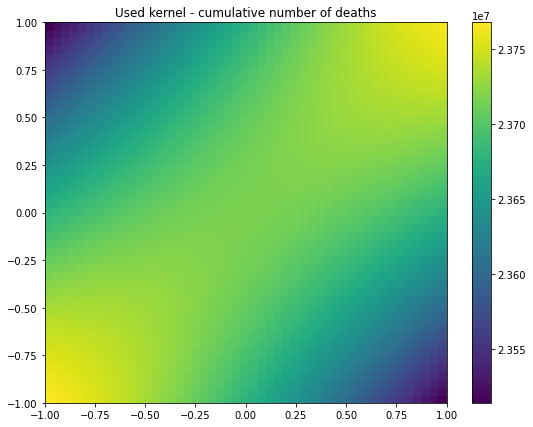

In [228]:
#visualize the kernel 
x = np.linspace(-1,1,50)
kernel = kkk(x[:, None])
plt.figure(figsize=(9,7))
plt.pcolor(x, x, kernel.reshape(len(x), len(x)))
plt.colorbar()
_=plt.title("Used kernel - cumulative number of deaths")

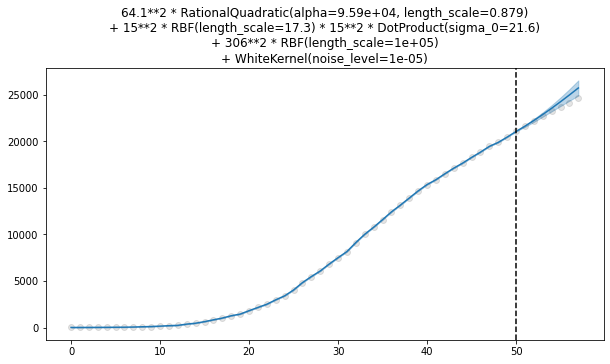

In [227]:
gp3 = GaussianProcessRegressor(kernel=kkk, alpha=0.01, normalize_y=True, n_restarts_optimizer=3)

gp3.fit(train_X, train_y)

plot_predictions(gp3)
_=plt.title(str(gp3.kernel_).replace(' +', '\n+'))

We can observe that the model tends to overestimate the number of deaths in the test set, however it is still an acceptable model (at least in my opinion!!).